<a href="https://colab.research.google.com/github/shahargonda/ClassicML/blob/main/Music_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Music Clustering

## premise

1. יש לקחת סיגנל אודיו המורכב מכמה כלים, ולנתח אותו באמצעים של למידה בלתי מונחית.
2. יש לאשכל את המקטעים השונים לפי המקצבים, תפקידים וכו'.
3. רמז: ניתן להשתמש בספריית ליברוסה על מנת לבצע טרנספורמציות מתאימות.
4. הכינו מצגת קצרה לסיכום העבודה (לא יותר מ15 דקות).

בהצלחה!


## wondering and brainstorming

שאלות:
מסתמכים בשלב הלמידה על יותר מקטע מוזיקלי יחיד? 
מה יש בדאטה?
מה אורך קטע צפוי?
רק אינסטרומטלי?

לאיזו מטרה מאשכלים?
מה פיצ'רים רלוונטיים?

?אותו תו/אותו כלי/אותו מקצב
וריאציה של מנגינה באוקטבות שונות?
בית/פזמון, סולמות, כלי מוביל


מחקר ראשוני: ליברוסה
האם יש פיצ'רים ברמות מידע שונות? 

In [4]:
# initial plan 

# load audio signal
# transform to audiogram
# visualize raw signal and audiogram
# maybe extract features from librosa at this stage (high\low level)
# visualize features on the data audiogram or while played or both
# decide how to cut
# maybe extract features from librosa at this stage (high\low level)
# cut and cluster
# visualize clusters on the data audiogram or while played or both

## Imports, Load

In [5]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats as st
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

import matplotlib.pyplot as plt
import matplotlib.transforms as mpt
import matplotlib.patches as patches

import librosa
import librosa.display

from IPython.display import Audio
SHOW_STREAMER=False


In [ ]:
# הקובץ צ"ל בתיקיה הראשית של המחברת
#audio_path='AiodeDemoSong.wav'
#y, sr = librosa.load(audio_path)

In [6]:
# read from s3 bucket
import soundfile as sf
import io
from six.moves.urllib.request import urlopen

url = 'https://aiodefilesbucket.s3.amazonaws.com/AiodeDemoSong.wav'

y, sr = sf.read(io.BytesIO(urlopen(url).read()))
y= y[1:,0]

In [7]:

hop_length = 512
BINS_PER_OCTAVE= 12*3
K=15
boundary_bin=[]

## Feature Extraction

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


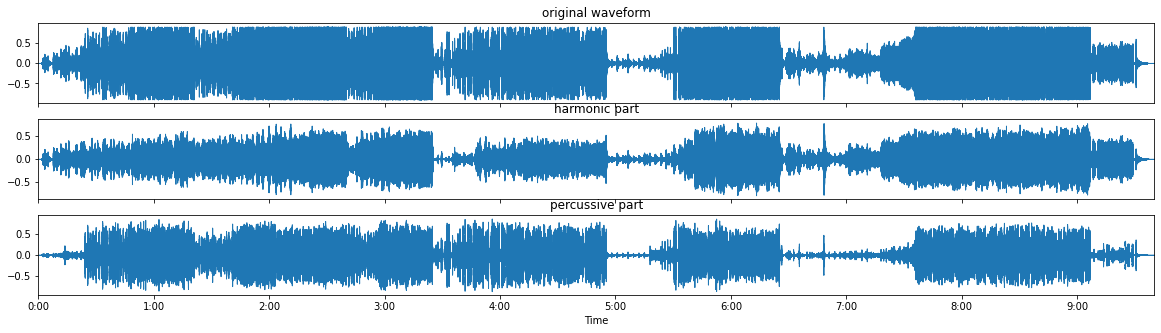

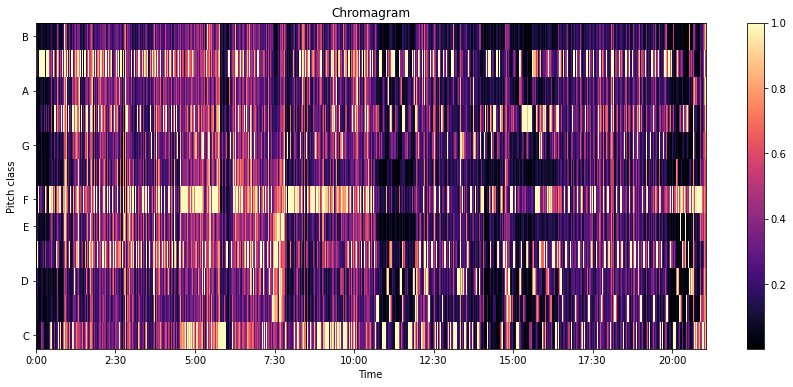

In [8]:
# MFCC, chromagram 
# source: https://librosa.org/doc/0.9.2/tutorial.html
# also the article: https://www.researchgate.net/publication/328777063_librosa_Audio_and_Music_Signal_Analysis_in_Python

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

fig, ax = plt.subplots(nrows=3, figsize=(15, 5))
librosa.display.waveplot(y, sr=sr, x_axis='time', offset=0.0, ax=ax[0])
ax[0].label_outer()
ax[0].set(title='original waveform')
#times = librosa.times_like(y, sr=sr, hop_length=hop_length)
#ax[0].plot(times, y_harmonic)
librosa.display.waveplot(y_harmonic, sr=sr, x_axis='time', offset=0.0, ax=ax[1])
ax[1].label_outer()
ax[1].set(title='harmonic part')
#ax[1].legend(frameon=True)
librosa.display.waveplot(y_percussive, sr=sr, x_axis='time', offset=0.0, ax=ax[2])
ax[2].set(title='percussive part')
plt.show()

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
beat_aligned_mfcc= librosa.util.sync(mfcc, beat_frames)

# And the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)
beat_aligned_mfcc_delta= librosa.util.sync(mfcc_delta, beat_frames)

# Stack and synchronize between beat events
# This time, we'll use the mean value (default) instead of median
timed_mfcc_mfcc_delta= np.vstack([mfcc, mfcc_delta])
beat_aligned_mfcc_mfcc_delta = librosa.util.sync(timed_mfcc_mfcc_delta, beat_frames)
                              
# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)
fig, ax = plt.subplots(figsize=(15,6))
img = librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram')
fig.colorbar(img, ax=ax)

# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_aligned_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

# Finally, stack all regular timed features and beat-synchronous features together
timed_features= np.vstack([mfcc, mfcc_delta, chromagram])
beat_aligned_features = np.vstack([beat_aligned_chroma, beat_aligned_mfcc_mfcc_delta])

In [ ]:
beat_times2= np.hstack([np.zeros(1),beat_times])
          
fig, ax = plt.subplots(nrows=3, figsize=(15, 10))
img = librosa.display.specshow(beat_aligned_mfcc, x_coords=beat_times2 ,x_axis='time', ax=ax[0], cmap='magma')
ax[0].set(title='Beat-alligned MFCC')
img = librosa.display.specshow(beat_aligned_mfcc_delta, x_coords=beat_times2 ,x_axis='time', ax=ax[1], cmap='magma')
ax[1].label_outer()
ax[1].set(title='Beat-alligned MFCC-delta')
img = librosa.display.specshow(beat_aligned_chroma, y_axis='chroma', x_coords=beat_times2, x_axis='time', ax=ax[2])
ax[2].set(title='Beat-alligned chromagram')
plt.tight_layout()
plt.show()

In [ ]:
# we'll crunch that later 

In [ ]:
# Tempo: 
# source: https://librosa.org/doc/main/generated/librosa.feature.tempogram.html#librosa.feature.tempogram

onset_frames = librosa.onset.onset_detect(y, sr=sr, delta=0.04, wait=4)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
onset_samples = librosa.frames_to_samples(onset_frames)

# Compute local onset autocorrelation
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]

fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')
plt.show()

## Functions' Definitions

In [ ]:
def scale(features):
  min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
  features_scaled = min_max_scaler.fit_transform(features)
  return features_scaled
def reduce_dimention_via_PCA(features, n_dims):
  return PCA(n_components=n_dims).fit_transform(features)
def reduce_dimentions_via_TSNE(features, n_dims, perplexity=15):
  return TSNE(n_components=n_dims, learning_rate='auto',init='random', perplexity=perplexity).fit_transform(features)

In [ ]:
def librosa_cluster_by_features(features, k):
  # librosa.segment: https://github.com/librosa/librosa/blob/main/librosa/segment.py
  boundaries = librosa.segment.agglomerative(features, k)
  # this is contrained already so the labels are just consecutive
  n= features.shape[1]
  labels= np.zeros(n)
  for label, (low, high) in enumerate(zip (boundaries, np.append(boundaries[1:],n))):
    #print(low, high)
    labels[low:high]= label
  
  return boundaries, labels

def plot_boundaries_on_whatevergram(labels, boundaries, whatevergram, info_str, **kwargs):
  # move boundries to time
  bound_times = librosa.frames_to_time(boundaries, sr=sr)
  fig, ax = plt.subplots(figsize=(25, 8))
  trans = mpt.blended_transform_factory(
              ax.transData, ax.transAxes)
  librosa.display.specshow(whatevergram, x_axis='time', ax=ax, **kwargs)
  ax.vlines(bound_times, 0, 1, color='linen', linestyle='--',
            linewidth=2, alpha=0.9, label='Segment boundaries',
            transform=trans)
  ax.legend()
  ax.set(title=info_str)
  plt.show()

def change_axis_features(features):
  # the time axis is last in librosa - let's swap it back to place 0 
  features = np.atleast_2d(features)
  # Swap data index to position 0
  features = np.swapaxes(features, -1, 0)
  return features

def play_clicks_at_boundaries(y, boundaries):
  clicks = librosa.clicks(frames=boundaries, sr=sr, length=len(y))
  Audio(data=(y + clicks)[:60*7*sr], rate=sr)


In [ ]:
# K-means Knee method for deciding on k 
# https://practicaldatascience.co.uk/machine-learning/how-to-use-knee-point-detection-in-k-means-clustering
!pip3 install kneed
from kneed import KneeLocator

def find_k(df, increment=0, decrement=0):
    """Find the optimum k clusters"""
    sse = {}
    
    for k in range(1, 15+1):
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df)
        sse[k] = kmeans.inertia_
    
    kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')
    k = kn.knee + increment - decrement
    return k


In [ ]:
def plot_2d_projections(features_PCA, features_tSNE, labels=None, title=''):
  fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,8))
  ax[0].scatter(features_PCA[:,0], features_PCA[:,1], c=labels)
  ax[0].set_xlabel('first component')
  ax[0].set_ylabel('second component')

  ax[1].scatter(features_tSNE[:,0], features_tSNE[:,1], c=labels)
  ax[1].set_xlabel('first tSNE magic axis')
  ax[1].set_ylabel('second tSNE magic axis')
  #plt.tight_layout()
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.suptitle(title)
  plt.show()

def plot_labels_on_time_axis(onset_times, labels, title=""):
  plt.figure(figsize=(15,5))
  plt.plot(onset_times, labels.astype('float'))
  plt.title(title)
  plt.xlabel('seconds')
  plt.show()  

In [ ]:
def cluster_from_features(features, onset_times, knee_plot=False, spectral_clustering=True, plot_projections=True):
  print ('features.shape', features.shape)
  features_scaled= scale(features)
  print ('features_scaled.shape',features_scaled.shape)

  if plot_projections:
    n_dims=2
    features_PCA= reduce_dimention_via_PCA(features_scaled, n_dims)
    features_tSNE= reduce_dimentions_via_TSNE(features_scaled, n_dims, perplexity=20)

    plot_2d_projections(features_PCA, features_tSNE, title='2-D Projections of the feature space')

  if knee_plot:
    Km_scores=[]
    for i in range(1,15+1):
      model = sklearn.cluster.KMeans(n_clusters=i)
      model.fit(features_scaled)
      Km_score= np.sum(np.min(model.transform(features_scaled), axis=1))
      Km_scores.append(Km_score)
    plt.plot(np.arange(1,15+1), Km_scores)
    plt.xticks(np.arange(1,15+1))
    plt.title('Cumulative distance from means for different Ks')
    plt.xlabel('K')
    plt.ylabel('Cumulative distance')
    plt.show()
    # I liked K=6, but knee-finder suggests k=4, so be it

  k= find_k(features_scaled)
  print('best evaluated k',k)

  model = sklearn.cluster.KMeans(n_clusters=k)
  Km_labels = model.fit_predict(features_scaled)
  print ('Km_labels.shape',Km_labels.shape)
  if plot_projections:
    plot_2d_projections(features_PCA,features_tSNE, Km_labels, 'K-means')
  plot_labels_on_time_axis(onset_times, Km_labels, 'K-means labels')

  
  gm_labels = GaussianMixture(n_components=k, random_state=0).fit_predict(features_scaled) #features2
  if plot_projections:
    plot_2d_projections(features_PCA,features_tSNE, gm_labels, 'GMM')
  plot_labels_on_time_axis(onset_times, gm_labels, 'GMM labels')

  sc_labels=[]
  if spectral_clustering:
    spectral_clustering_model= SpectralClustering(n_clusters=k, assign_labels='discretize')
    sc_labels=spectral_clustering_model.fit_predict(features_scaled)
    if plot_projections:
      plot_2d_projections(features_PCA,features_tSNE, sc_labels, 'Spectral Clustering')
    plot_labels_on_time_axis(onset_times, sc_labels, 'Spectral Clustering labels')

  return Km_labels, gm_labels, sc_labels

# Clustering

## Instrument clustering: using MFCC features

In [ ]:
# 1. MFCC information clustering- concerning the spectral envelope. hope it gives instrument analysis!
k=K # number of segments 
MFCC_boundaries, MFCC_labels= librosa_cluster_by_features(mfcc, k)
if boundary_bin==[]:
  boundary_bin=MFCC_boundaries
else:
  boundary_bin= np.vstack([boundary_bin,MFCC_boundaries ])
#print (MFCC_boundaries)
plot_boundaries_on_whatevergram(MFCC_labels, MFCC_boundaries, mfcc, "MFCC coefs. clustering based on MFCC information only", cmap='magma')
if SHOW_STREAMER:
  clicks = librosa.clicks(frames=MFCC_boundaries, sr=sr, length=len(y))
  Audio(data=(y + clicks)[:60*7*sr], rate=sr)

In [ ]:
  #script echo skipping
  # audio playing keeps crashing my notebook
  clicks = librosa.clicks(frames=MFCC_boundaries, sr=sr, length=len(y))
  Audio(data=(y + clicks)[:60*7*sr], rate=sr)

In [ ]:
# convincing! but can we do it with regular machine learning techniques? 

In [ ]:
print(beat_aligned_mfcc.shape)
ba_mfcc=change_axis_features(beat_aligned_mfcc)
features= scale(ba_mfcc)

#onset_times=beat_times2
print(ba_mfcc.shape)
print(beat_times2.shape)

In [ ]:
ba_mfcc_axis=change_axis_features(beat_aligned_mfcc)
MFCC_Km_labels, MFCC_gm_labels, MFCC_sc_labels= cluster_from_features(ba_mfcc_axis, beat_times2)

In [ ]:
def accumulate_by_label(labels_vector, label, y, beat_times, verbose=False):
  timeline=np.squeeze(np.where(labels_vector==label))
  if verbose:
    print(timeline)
    #print(timeline[0:-2])
  #beat_times2[timeline]
  low= np.squeeze([beat_times[time] for time in timeline[:-1]])
  high= np.squeeze([beat_times[time+1] for time in timeline[:-1]])
  couples=list(zip(low,high))

  acc_frames=np.zeros(1)
  for low, high in couples:
    #print(low,high)
    acc_frames= np.hstack([acc_frames,y[int(low*sr):int(high*sr)]])
  return acc_frames

acc_frames= accumulate_by_label(MFCC_gm_labels, 0, y, beat_times2)
Audio(acc_frames, rate=sr)

In [ ]:
acc_frames= accumulate_by_label(MFCC_gm_labels, 3, y, beat_times2)
Audio(acc_frames, rate=sr)

### Tangent: label by beat

In [ ]:
# assign label with each instrument onset
#idea source: https://musicinformationretrieval.com/index.html

onset_frames = librosa.onset.onset_detect(y, sr=sr, delta=0.04, wait=4)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
onset_samples = librosa.frames_to_samples(onset_frames)

# all recognized onsets
y_beeps = librosa.clicks(onset_times, sr, length=len(y))
Audio((y + y_beeps)[:60*sr], rate=sr)

def extract_features(y, sr):
    zcr = librosa.zero_crossings(y).sum()
    energy = scipy.linalg.norm(y)
    mfccs = librosa.feature.mfcc(y, sr=sr).mean(axis=1)
    return [zcr, energy, *mfccs]

frame_sz = int(sr*0.090)
features = np.array([extract_features(y[i:i+frame_sz], sr) for i in onset_samples])

In [ ]:
features_scaled= scale(features)

n_dims=2
features_PCA= reduce_dimention_via_PCA(features_scaled, n_dims)
features_tSNE= reduce_dimentions_via_TSNE(features_scaled, n_dims, perplexity=20)

plot_2d_projections(features_PCA, features_tSNE, title='2-D Projections of the feature space')

Km_scores=[]
for i in range(1,19+1):
  model = sklearn.cluster.KMeans(n_clusters=i)
  model.fit(features_scaled)
  Km_score= np.sum(np.min(model.transform(features_scaled), axis=1))
  Km_scores.append(Km_score)
plt.plot(np.arange(1,19+1), Km_scores)
plt.xticks(np.arange(1,19+1))
plt.title('Cumulative distance from means for different Ks')
plt.xlabel('K')
plt.ylabel('Cumulative distance')
plt.show()
# I liked K=6, but knee-finder suggests k=4, so be it

k= find_k(features_scaled)
print('best evaluated k',k)

model = sklearn.cluster.KMeans(n_clusters=k)
Km_labels = model.fit_predict(features_scaled)
plot_2d_projections(features_PCA,features_tSNE, Km_labels, 'K-means')
plot_labels_on_time_axis(onset_times, Km_labels, 'K-means labels')

from sklearn.mixture import GaussianMixture
gm_labels = GaussianMixture(n_components=k, random_state=0).fit_predict(features_scaled) #features2
plot_2d_projections(features_PCA,features_tSNE, gm_labels, 'GMM')
plot_labels_on_time_axis(onset_times, gm_labels, 'GMM labels')

from sklearn.cluster import SpectralClustering
spectral_clustering_model= SpectralClustering(n_clusters=k, assign_labels='discretize')
sc_labels=spectral_clustering_model.fit_predict(features_scaled)
plot_2d_projections(features_PCA,features_tSNE, sc_labels, 'Spectral Clustering')
plot_labels_on_time_axis(onset_times, sc_labels, 'Spectral Clustering labels')


In [ ]:
# hear all labels at once
def create_beep_pattern(labels):
  y_beeps= librosa.clicks(times=[0] ,sr=sr, click_freq=1, length=len(y))
  for i,label in enumerate(np.unique(labels)):
    y_beeps += librosa.clicks(onset_times[labels==label], sr, click_freq=800.0+200*i, length=len(y))
  return y_beeps


In [ ]:
%%script echo skipping
# audio playing keeps crashing my notebook

# example: seems that all clustering algorithms agree on this interval: 
y_beeps=create_beep_pattern(sc_labels)  
Audio((y + y_beeps)[450*sr:600*sr], rate=sr)

In [ ]:
%%script echo skipping
# audio playing keeps crashing my notebook

# and this one, with only the keyboard playing
init_seconds=0
end_seconds= 30
Audio((y)[init_seconds*sr:end_seconds*sr], rate=sr)

## Cluster using Chroma features- melody information?

In [ ]:
# 1. Chroma features and clustering 
k=K
Chroma_boundaries, Chroma_labels= librosa_cluster_by_features(chromagram, k)
if boundary_bin==[]:
  boundary_bin=Chroma_boundaries
else:
  boundary_bin= np.vstack([boundary_bin,Chroma_boundaries ])
#print(librosa.frames_to_time(Chroma_boundaries, sr=sr))
print (Chroma_boundaries)
plot_boundaries_on_whatevergram(Chroma_labels, Chroma_boundaries, chromagram, "Power spectrogram. Chromagram information only", y_axis='chroma')
if SHOW_STREAMER:
  clicks = librosa.clicks(frames=Chroma_boundaries, sr=sr, length=len(y))
  Audio(data=(y + clicks)[:60*7*sr], rate=sr)

In [ ]:
#%%script echo skipping
# audio playing keeps crashing my notebook

clicks = librosa.clicks(frames=Chroma_boundaries, sr=sr, length=len(y))
Audio(data=(y + clicks)[60*2*sr:60*7*sr], rate=sr)

In [ ]:
ba_chroma_axis=change_axis_features(beat_aligned_chroma)
Chroma_Km_labels, Chroma_gm_labels, Chroma_sc_labels= cluster_from_features(ba_chroma_axis, beat_times2)

In [ ]:
#%%script echo skipping
# audio playing keeps crashing my notebook

acc_frames= accumulate_by_label(Chroma_gm_labels, 0, y, beat_times2)
Audio(acc_frames, rate=sr)

In [ ]:
# unfortunately the time constrains are important here- 
#the clustering that doesn't constrain it does a lot worse. 

## Tempo clustering: using tempogram features

In [ ]:
# 3. Tempogram - hope it gives tempo clustering
k=K
tempo_boundaries, tempo_labels= librosa_cluster_by_features(tempogram, k)
if boundary_bin==[]:
  boundary_bin=tempo_boundaries
else:
  boundary_bin= np.vstack([boundary_bin,tempo_boundaries ])
print (tempo_boundaries)
plot_boundaries_on_whatevergram(tempo_labels, tempo_boundaries, chromagram, "Clustering using Tempogram information only",
                  y_axis='chroma', sr=sr)
if SHOW_STREAMER:
  clicks = librosa.clicks(frames=tempo_boundaries, sr=sr, length=len(y))
  Audio(data=(y + clicks)[:60*7*sr], rate=sr)

In [ ]:
%%script echo skipping
# audio playing keeps crashing my notebook
clicks = librosa.clicks(frames=tempo_boundaries, sr=sr, length=len(y))
Audio(data=(y + clicks)[int(60*4.5*sr):int(60*9*sr)], rate=sr)

In [ ]:
tempo_axis=change_axis_features(tempogram)
print(tempo_axis.shape)

# there are 384 features. Let's reduce them
tempo_axis_reduced=reduce_dimention_via_PCA(tempo_axis, n_dims=20)
print(tempo_axis_reduced.shape)
# also too many lines, but i don't want to subsample

In [ ]:
tempo_Km_labels, tempo_gm_labels, tempo_sc_labels= cluster_from_features(tempo_axis_reduced, onset_times=times, knee_plot=False, spectral_clustering=False, plot_projections=False) 

In [ ]:
acc_frames= accumulate_by_label(tempo_Km_labels, 3, y, times, verbose=True)
print(acc_frames)
Audio(acc_frames, rate=sr)

In [ ]:
# it works!

## Catchall clustering

In [ ]:
# 4. cluster by all timed features at once: 
k=K
catchall_boundaries, catchall_labels= librosa_cluster_by_features(timed_features, k)
if boundary_bin==[]:
  boundary_bin=catchall_boundaries
else:
  boundary_bin= np.vstack([boundary_bin,catchall_boundaries ])
print (catchall_boundaries)
plot_boundaries_on_whatevergram(catchall_labels, catchall_boundaries, chromagram, "Clustering using all features",
                  y_axis='chroma', sr=sr)
# answers are very close to those of the MFCC. maybe time to normalize? :)

In [ ]:
print(boundary_bin)

In [ ]:
# this is very similar to the boundaries aquired from SFCC alone. 

## Bonus- Laplacian segmentation


In [ ]:
'''
======================
Laplacian segmentation
======================

This notebook implements the laplacian segmentation method of
`McFee and Ellis, 2014 <http://bmcfee.github.io/papers/ismir2014_spectral.pdf>`_,
with a couple of minor stability improvements.

Throughout the example, we will refer to equations in the paper by number, so it will be
helpful to read along.
'''

# Code source: Brian McFee
# License: ISC


###################################
# Imports
#   - numpy for basic functionality
#   - scipy for graph Laplacian
#   - matplotlib for visualization
#   - sklearn.cluster for K-Means
#
from __future__ import print_function

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sklearn.cluster

import librosa
import librosa.display

#############################
# First, we'll load in a song

# I commented this part
#y, sr = librosa.load('audio/Karissa_Hobbs_-_09_-_Lets_Go_Fishin.mp3')


##############################################
# Next, we'll compute and plot a log-power CQT
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
C = librosa.amplitude_to_db(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE),
                            ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
plt.tight_layout()


##########################################################
# To reduce dimensionality, we'll beat-synchronous the CQT
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

# For plotting purposes, we'll need the timing of the beats
# we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                            x_min=0,
                                                            x_max=C.shape[1]),
                                    sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_times)
plt.tight_layout()


#####################################################################
# Let's build a weighted recurrence matrix using beat-synchronous CQT
# (Equation 1)
# width=3 prevents links within the same bar
# mode='affinity' here implements S_rep (after Eq. 8)
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity',
                                      sym=True)

# Enhance diagonals with a median filter (Equation 2)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))


###################################################################
# Now let's build the sequence matrix (S_loc) using mfcc-similarity
#
#   :math:`R_\text{path}[i, i\pm 1] = \exp(-\|C_i - C_{i\pm 1}\|^2 / \sigma^2)`
#
# Here, we take :math:`\sigma` to be the median distance between successive beats.
#
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)


##########################################################
# And compute the balanced combination (Equations 6, 7, 9)

deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path


###########################################################
# Plot the resulting graphs (Figure 1, left and center)
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time',
                         y_coords=beat_times)
plt.title('Recurrence similarity')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_path, cmap='inferno_r')
plt.title('Path similarity')
plt.subplot(1, 3, 3)
librosa.display.specshow(A, cmap='inferno_r')
plt.title('Combined graph')
plt.tight_layout()


#####################################################
# Now let's compute the normalized Laplacian (Eq. 10)
L = scipy.sparse.csgraph.laplacian(A, normed=True)


# and its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)


# We can clean this up further with a median filter.
# This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))


# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k

k = 7

X = evecs[:, :k] / Cnorm[:, k-1:k]

# Plot the resulting representation (Figure 1, center and right)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')

plt.subplot(1, 2, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure components')
plt.tight_layout()


#############################################################
# Let's use these k components to cluster beats into segments
# (Algorithm 1)
KM = sklearn.cluster.KMeans(n_clusters=k)

seg_ids = KM.fit_predict(X)

# and plot the results
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)

plt.subplot(1, 3, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')
plt.subplot(1, 3, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure components')
plt.subplot(1, 3, 3)
librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=colors)
plt.title('Estimated segments')
plt.colorbar(ticks=range(k))
plt.tight_layout()


###############################################################
# Locate segment boundaries from the label sequence
bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])

# Count beat 0 as a boundary
bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)

# Compute the segment label for each boundary
bound_segs = list(seg_ids[bound_beats])

# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Make sure we cover to the end of the track
bound_frames = librosa.util.fix_frames(bound_frames,
                                       x_min=None,
                                       x_max=C.shape[1]-1)

###################################################
# And plot the final segmentation over original CQT


# sphinx_gallery_thumbnail_number = 5

import matplotlib.patches as patches
plt.figure(figsize=(12, 4))

bound_times = librosa.frames_to_time(bound_frames)
freqs = librosa.cqt_frequencies(n_bins=C.shape[0],
                                fmin=librosa.note_to_hz('C1'),
                                bins_per_octave=BINS_PER_OCTAVE)

#librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
#                         bins_per_octave=BINS_PER_OCTAVE,
#                         x_axis='time')
librosa.display.specshow(chromagram, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
ax = plt.gca()

for interval, label in zip(zip(bound_times, bound_times[1:]), bound_segs):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))

plt.tight_layout()
plt.show()

#clicks = librosa.clicks(frames=bound_frames, sr=sr, length=len(y))
#Audio(data=(y + clicks)[:int(60*9*sr)], rate=sr)

In [ ]:
clicks = librosa.clicks(frames=bound_frames, sr=sr, length=len(y))
Audio(data=(y + clicks)[int(60*3*sr):int(60*9*sr)], rate=sr)

## Unsucceessful attempt: Refrains

In [ ]:
# refrains: repeating sequences are supposed to appear as diagonals on a time-time recurrence matrix
# in our case it doesn't really show, nor doest it show on a time-lag matrix as horizontals

recurrence = librosa.segment.recurrence_matrix(beat_aligned_features,
                                       mode='affinity',
                                       sym=True)
plt.figure(figsize=(10, 8))
librosa.display.specshow(recurrence)
plt.colorbar()

# lag representation
lag_nopad = librosa.segment.recurrence_to_lag(recurrence, pad=False)
plt.figure(figsize=(10, 8))
librosa.display.specshow(lag_nopad)
plt.colorbar()

I'm also not the only one who didn't make out the referain:

In [ ]:
# source: https://github.com/vivjay30/pychorus

!pip install pychorus

from pychorus import create_chroma
from pychorus.similarity_matrix import TimeTimeSimilarityMatrix, TimeLagSimilarityMatrix

chroma, _, sr, _ = create_chroma(audio_path)
time_time_similarity = TimeTimeSimilarityMatrix(chroma, sr)
time_lag_similarity = TimeLagSimilarityMatrix(chroma, sr)

# Visualize the results
time_time_similarity.display()
time_lag_similarity.display()

from pychorus import find_and_output_chorus

chorus_start_sec = find_and_output_chorus(audio_path, 'saved_chorus.wav', 15)

#Audio('saved_chorus.wav',rate=sr)


# #TODO

In [ ]:
# force K on clustering

# quantify agreement between clustering labels
# save audios
# get rid of duplicated computation in graphing deciding K
# extract boundaries from labels and compare with librosa's baseling boundaries

## salvage

In [ ]:
print(mfcc.shape, mfcc_delta.shape, chromagram.shape)
timed_features= np.vstack([mfcc, mfcc_delta, chromagram])
timed_features.shape

# the time axis is last for some strange reason- let's swap them
timed_features = np.atleast_2d(timed_features)
# Swap data index to position 0
timed_features = np.swapaxes(timed_features, -1, 0)

print(timed_features.shape)

In [ ]:
#
#seg_id_modes= pd.rolling_apply(pd.DataFrame(seg_ids), 10, np.mode)
seg_id_modes= pd.Series(seg_ids).rolling(128, min_periods=1).apply(lambda x: st.mode(x).mode)
seg_id_modes_of_modes= pd.Series(seg_id_modes).rolling(128, min_periods=1).apply(lambda x: st.mode(x).mode)
plt.figure(figsize=(25,5))
plt.plot(seg_ids, color='b')
plt.plot(seg_id_modes, color='r')
plt.plot(seg_id_modes_of_modes, color='k')
plt.show()



In [ ]:
# source: https://github.com/librosa/tutorial/blob/master/Librosa%20tutorial.ipynb

tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)
print(beats[:10])

clicks = librosa.clicks(frames=beats, sr=sr, length=len(y))

# I really dislike this automatic beat extraction
Audio(data=(y + clicks)[:60*3*sr], rate=sr)